### Lunar Lander - RL Expected Sarsa (Deep Learning Function Approximation)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl
%matplotlib inline
# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')


import numpy as np

from rl_glue import RLGlue
from lunar_lander import LunarLanderEnvironment
from base_agent import  BaseAgent
#from nn.action_value_network import ActionValueNetwork
from nn.action_value_network_nn import ActionValueNetwork
# from nn.softmax import softmax
from nn.softmax_torch import softmax
from nn.adam_optimizer import Adam
from nn.replay_buffer import ReplayBuffer
from plot_script import plot_result


from collections import deque

# # tensorflow imports
# import tensorflow as tf
# from tensorflow import keras

from copy import deepcopy
from tqdm import tqdm
import os 
import shutil
import datetime

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary








In [16]:

def get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau):
    """
    Args:
        states (Numpy array): The batch of states with the shape (batch_size, state_dim).
        next_states (Numpy array): The batch of next states with the shape (batch_size, state_dim).
        actions (Numpy array): The batch of actions with the shape (batch_size,).
        rewards (Numpy array): The batch of rewards with the shape (batch_size,).
        discount (float): The discount factor.
        terminals (Numpy array): The batch of terminals with the shape (batch_size,).
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    Returns:
        The TD errors (Numpy array) for actions taken, of shape (batch_size,)
    """
    
    # Note: Here network is the latest state of the network that is getting replay updates. In other words, 
    # the network represents Q_{t+1}^{i} whereas current_q represents Q_t, the fixed network used for computing the 
    # targets, and particularly, the action-values at the next-states.
    
    # Compute action values at next states using current_q network
    # Note that q_next_mat is a 2D array of shape (batch_size, num_actions)
    
    ### START CODE HERE (~1 Line)
    q_next_mat = current_q.get_action_values(next_states)
    #q_next_mat = current_q(next_states)
    ### END CODE HERE
    
    # Compute policy at next state by passing the action-values in q_next_mat to softmax()
    # Note that probs_mat is a 2D array of shape (batch_size, num_actions)
    
    ### START CODE HERE (~1 Line)
    probs_mat = softmax(q_next_mat, tau)
    ### END CODE HERE
    
    # Compute the estimate of the next state value, v_next_vec.
    # Hint: sum the action-values for the next_states weighted by the policy, probs_mat. Then, multiply by
    # (1 - terminals) to make sure v_next_vec is zero for terminal next states.
    # Note that v_next_vec is a 1D array of shape (batch_size,)
    
    ### START CODE HERE (~3 Lines)
    v_next_vec = np.sum(probs_mat * q_next_mat, axis = 1) * (1 - terminals)
    ### END CODE HERE
    
    # Compute Expected Sarsa target
    # Note that target_vec is a 1D array of shape (batch_size,)
    
    ### START CODE HERE (~1 Line)
    target_vec = rewards + discount * v_next_vec
    ### END CODE HERE
    
    # Compute action values at the current states for all actions using network
    # Note that q_mat is a 2D array of shape (batch_size, num_actions)
    
    ### START CODE HERE (~1 Line)
    q_mat = network.get_action_values(states)
    #q_mat = network(states)   
    ### END CODE HERE
    
    # Select q(s,a) from q_mat for taken actions only by masking with one-hot
    # actions encoding
    #mask = tf.one_hot(actions, q_mat.shape[1])
    #q_vec = tf.reduce_sum(q_mat * mask, axis=1)
    
    # Batch Indices is an array from 0 to the batch size - 1. 
    batch_indices = np.arange(q_mat.shape[0])

    # Compute q_vec by selecting q(s, a) from q_mat for taken actions
    # Use batch_indices as the index for the first dimension of q_mat
    # Note that q_vec is a 1D array of shape (batch_size)
    
    ### START CODE HERE (~1 Line)
    ### Did not work for Gradient Tape as q_mat has to be converted into NumPy
    q_vec = q_mat[batch_indices, actions]
    ### END CODE HERE
    
    # Compute TD errors for actions taken
    # Note that delta_vec is a 1D array of shape (batch_size)
    
    ### START CODE HERE (~1 Line)
    delta_vec = target_vec - q_vec
    ### END CODE HERE
    
    #return target_vec, q_vec
    return delta_vec

In [17]:
#loss_fn = keras.losses.mean_squared_error


def optimize_network(experiences, discount, optimizer, network, current_q, tau):
    """
    Args:
        experiences (Numpy array): The batch of experiences including the states, actions, 
                                   rewards, terminals, and next_states.
        discount (float): The discount factor.
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    """
    
    # Get states, action, rewards, terminals, and next_states from experiences
    states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    states = np.concatenate(states)
    next_states = np.concatenate(next_states)
    rewards = np.array(rewards)
    terminals = np.array(terminals)
    batch_size = states.shape[0]
    #print(states.shape)
    

    # Compute TD error using the get_td_error function
    # Note that q_vec is a 1D array of shape (batch_size)
    delta_vec = get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau)
    
    # q_next_mat = current_q.predict(next_states)
    # probs_mat = softmax(q_next_mat, tau)
    # v_next_vec = np.sum(probs_mat * q_next_mat, axis = 1) * (1 - terminals)
    # target_vec = rewards + discount * v_next_vec
    # mask = tf.one_hot(actions, q_next_mat.shape[1])
    # 
    # with tf.GradientTape() as tape:
    #      q_mat = network(states)        
    #      q_vec = tf.reduce_sum(tf.multiply(q_mat, mask), axis=1, keepdims=True)
    #      loss = tf.reduce_mean(loss_fn(target_vec, q_vec))
    #      #loss = tf.reduce_mean(target_vec - q_vec)
    # grads = tape.gradient(loss, network.trainable_variables) # this should result td error times gradient
    # optimizer.apply_gradients(zip(grads, network.trainable_variables))
    
    

    # Batch Indices is an array from 0 to the batch_size - 1. 
    batch_indices = np.arange(batch_size)

    # Make a td error matrix of shape (batch_size, num_actions)
    # delta_mat has non-zero value only for actions taken
    delta_mat = np.zeros((batch_size, network.num_actions))
    delta_mat[batch_indices, actions] = delta_vec

    # Pass delta_mat to compute the TD errors times the gradients of the network's weights from back-propagation

    ### START CODE HERE
    td_update = network.get_TD_update(states, delta_mat)
    ### END CODE HERE

    # Pass network.get_weights and the td_update to the optimizer to get updated weights
    ### START CODE HERE
    weights = optimizer.update_weights(network.weights, td_update)
    ### END CODE HERE

    network.set_weights(weights)
    #current_q.set_weights(network.get_weights())


In [ ]:
loss_fn = nn.MSELoss(reduction='mean')


def optimize_network_nn(experiences, discount, optimizer, network, current_q, tau):
    """
    Args:
        experiences (Numpy array): The batch of experiences including the states, actions, 
                                   rewards, terminals, and next_states.
        discount (float): The discount factor.
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    """
    
    # Get states, action, rewards, terminals, and next_states from experiences
    states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    states = np.concatenate(states)
    next_states = np.concatenate(next_states)
    rewards = np.array(rewards)
    terminals = np.array(terminals)
    batch_size = states.shape[0]
    #print(states.shape)
    
    next_states = torch.from_numpy(next_states).float()
    q_next_mat = current_q(next_states)
    probs_mat = softmax(q_next_mat, tau)
    v_next_vec = torch.sum(probs_mat * q_next_mat, dim = 1) * (1 - torch.from_numpy(terminals))
    target_vec = torch.from_numpy(rewards) + discount * v_next_vec
    
    states = torch.from_numpy(states).float()
    q_mat = network(states)
    #q_mat = q_mat.detach().numpy()
    batch_indices = torch.arange(batch_size)
    q_vec = q_mat[batch_indices, actions]
    # print(q_vec.shape)
    # print(target_vec.shape)
    #loss = loss_fn(target_vec, q_vec)
    loss = F.smooth_l1_loss(target_vec, q_vec) # Huber Loss
    # zero the parameter gradients
    optimizer.zero_grad()   
    #loss.requires_grad = True
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(network.parameters(), 1)
    optimizer.step()


In [3]:
class Agent(BaseAgent):
    def __init__(self):
        self.name = "expected_sarsa_agent"
        
    # Work Required: No.
    def agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            network_config: dictionary,
            optimizer_config: dictionary,
            replay_buffer_size: integer,
            minibatch_sz: integer, 
            num_replay_updates_per_step: float
            discount_factor: float,
        }
        """
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], 
                                           agent_config['minibatch_sz'], agent_config.get("seed"))
        
        # self.network = ActionValueNetwork(agent_config['network_config'])
        # self.optimizer = Adam(self.network.layer_sizes, agent_config["optimizer_config"])
        # avn = ActionValueNetwork(agent_config['network_config'])
        # self.network = avn.get_action_values_keras()
        # self.optimizer = keras.optimizers.Adam(lr=agent_config['optimizer_config']['step_size'], 
        #                                        beta_1 = agent_config['optimizer_config']['beta_m'], 
        #                                        beta_2= agent_config['optimizer_config']['beta_v'], 
        #                                        epsilon=agent_config['optimizer_config']['epsilon'])
        # self.current_q = avn.get_current_q()
        
        self.network = ActionValueNetwork(agent_config['network_config'])
        summary(self.network, (8,))
        self.optimizer = optim.Adam(self.network.parameters(), lr=agent_config['optimizer_config']['step_size'])
        self.current_q = ActionValueNetwork(agent_config['network_config']) 
        self.current_q.load_state_dict(self.network.state_dict())  # copy weights and stuff            
        
        
        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))
        
        self.last_state = None
        self.last_action = None
        
        self.sum_rewards = 0
        self.episode_steps = 0
        
        self.network_config = agent_config['network_config']

    # Work Required: No.
    def policy(self, state):
        """
        Args:
            state (Numpy array): the state.
        Returns:
            the action. 
        """
        # action_values = self.network.get_action_values(state)
        # print(action_values)
        # print(action_values.shape)
        state = torch.from_numpy(state).float()
        with torch.no_grad():
            action_values = self.network(state)
        # action_values = action_values.numpy()            
        # print(action_values)
        # print(action_values.shape)
                
        #action_values = self.network.predict(state)
        probs_batch = softmax(action_values, self.tau)
        probs_batch = probs_batch.numpy()
        # print(probs_batch)
        action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        # print(action)
        return action

    # Work Required: No.
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = np.array([state])
        self.last_action = self.policy(self.last_state)
        return self.last_action

    # Work Required: Yes. Fill in the action selection, replay-buffer update, 
    # weights update using optimize_network, and updating last_state and last_action (~5 lines).
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        
        self.sum_rewards += reward
        self.episode_steps += 1

        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the get_action_values() and get_TD_update() functions
        state = np.array([state])

        # Select action
        ### START CODE HERE (~1 Line)
        action = self.policy(state)
        ### END CODE HERE
        
        # Append new experience to replay buffer
        # Note: look at the replay_buffer append function for the order of arguments

        ### START CODE HERE (~1 Line)
        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)
        ### END CODE HERE
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            # current_q = deepcopy(self.network)
            # #current_q = keras.models.clone_model(self.network)
            # #current_q.set_weights(self.network.get_weights())
            # # deep copy pytorch nn model
            current_q = self.current_q 
            current_q.load_state_dict(self.network.state_dict())  # copy weights and stuff            
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network (~1 Line)
                ### START CODE HERE
                optimize_network_nn(experiences, self.discount, self.optimizer, self.network, current_q, self.tau) 
                ### END CODE HERE
                
        # Update the last state and last action.
        ### START CODE HERE (~2 Lines)
        self.last_state = state
        self.last_action = action
        ### END CODE HERE
        
        return action

    # Work Required: Yes. Fill in the replay-buffer update and
    # update of the weights using optimize_network (~2 lines).
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.sum_rewards += reward
        self.episode_steps += 1
        
        # Set terminal state to an array of zeros
        state = np.zeros_like(self.last_state)

        # Append new experience to replay buffer
        # Note: look at the replay_buffer append function for the order of arguments
        
        ### START CODE HERE (~1 Line)
        self.replay_buffer.append(self.last_state, self.last_action, reward, 1, state)
        ### END CODE HERE
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            # current_q = deepcopy(self.network)
            # #current_q = keras.models.clone_model(self.network)
            # #current_q = self.current_q
            # #current_q.set_weights(self.network.get_weights())
            # deep copy pytorch nn model
            current_q = self.current_q 
            current_q.load_state_dict(self.network.state_dict())  # copy weights and stuff            
            
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network
                ### START CODE HERE (~1 Line)
                optimize_network_nn(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)
                ### END CODE HERE
                
        
    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")
        
    def agent_model(self):
        return self.network

In [42]:
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    
    rl_glue = RLGlue(environment, agent)
        
    # save sum of reward at the end of each episode
    agent_sum_reward = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes"]))

    env_info = {"env_name":"LunarLander-v2"}

    agent_info = agent_parameters
    
    # one agent setting
    for run in range(1, experiment_parameters["num_runs"]+1):
        agent_info["seed"] = run
        agent_info["network_config"]["seed"] = run
        env_info["seed"] = run
        # tf.random.set_seed(run)
        print("Initializing Agent..")
        rl_glue.rl_init(agent_info, env_info)
        print("Agent Loaded!")
        for episode in tqdm(range(1, experiment_parameters["num_episodes"]+1)):
            # run episode
            rl_glue.rl_episode(experiment_parameters["timeout"])
            episode_reward = rl_glue.rl_agent_message("get_sum_reward")
            agent_sum_reward[run - 1, episode - 1] = episode_reward
        rl_glue.rl_cleanup()
    save_name = "{}".format(rl_glue.agent.name)
    if not os.path.exists('results'):
        os.makedirs('results')
    np.save("results/sum_reward_{}".format(save_name), agent_sum_reward)
    shutil.make_archive('results', 'zip', 'results')
    model = rl_glue.rl_agent_model()
    torch.save(model, experiment_parameters['model_path']+save_name+".pth")

# Run Experiment

# Experiment parameters
experiment_parameters = {
    "num_runs" : 1,
    "num_episodes" : 300,
    # OpenAI Gym environments allow for a timestep limit timeout, causing episodes to end after 
    # some number of timesteps. Here we use the default of 1000.
    "timeout" : 1000,
    'model_path':'results/'    
}

# Environment parameters
environment_parameters = {}

current_env = LunarLanderEnvironment

# Agent parameters
agent_parameters = {
    'network_config': {
        'state_dim': 8,
        'num_hidden_units': 256,
        'num_actions': 4
    },
    'optimizer_config': {
        'step_size': 1e-3,
        'beta_m': 0.9, 
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'replay_buffer_size': 50000,
    'minibatch_sz': 8,
    'num_replay_updates_per_step': 4,
    'gamma': 0.99,
    'tau': 0.001

}
current_agent = Agent

# run experiment
run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

  0%|          | 0/300 [00:00<?, ?it/s]

Initializing Agent..
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]           2,304
            Linear-2                    [-1, 4]           1,028
Total params: 3,332
Trainable params: 3,332
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
Agent Loaded!


100%|██████████| 300/300 [20:32<00:00,  4.11s/it]


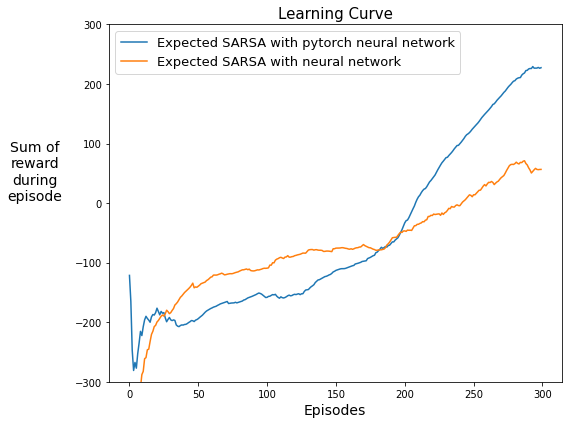

In [43]:
plot_result(["expected_sarsa_agent","old_expected_sarsa_agent"])

In [3]:
data_name = 'old_expected_sarsa_agent'
path_dict = {"old_expected_sarsa_agent": "results/",
             "random_agent": "./"}
filename = 'sum_reward_{}'.format(data_name).replace('.', '')
sum_reward_data = np.load('{}/{}.npy'.format(path_dict[data_name], filename))
sum_reward_data.shape

(1, 300)

### Display RL Agent landing craft based on actions predicted by model

In [44]:
import gym


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,


def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim


def render_policy_net(model, tau=0.001, num_actions=4, n_max_steps=1000, seed=42):
    frames = []
    env = gym.make("LunarLander-v2")
    env = gym.wrappers.Monitor(env, 'results/video/lander_network_policy.mp4', force=True)
    env._max_episode_steps = 1500
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):       
        state = torch.from_numpy(obs).float()
        # print(state.shape)
        state = state.view(1, -1)
        with torch.no_grad():
            action_values = model(state)
        probs_batch = softmax(action_values, tau)
        probs_batch = probs_batch.numpy()
        rand_generator = np.random.RandomState(seed)
        action = rand_generator.choice(num_actions, p=probs_batch.squeeze())
        obs, reward, done, info = env.step(action)
        if done:
            print(step)
            break
        frames.append(env.render(mode="rgb_array"))
    env.close()
    return frames

def render_random_policy(num_actions=4, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("LunarLander-v2")
    env = gym.wrappers.Monitor(env, 'results/video/', force=True)
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        action = np.random.randint(num_actions)
        # action = np.random.randn(num_actions)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frames.append(env.render(mode='rgb_array'))
    env.close()
    return frames



In [45]:
MODEL_PATH='results/expected_sarsa_agent.pth'
model = torch.load(MODEL_PATH)
frames = render_policy_net(model, tau=0.001, num_actions=4, n_max_steps=8000, seed=42)


539


In [46]:
plot_animation(frames)

### Display RL Agent landing craft based on random actions

In [47]:
rand_frames = render_random_policy(n_max_steps=1500)


In [48]:
plot_animation(rand_frames)

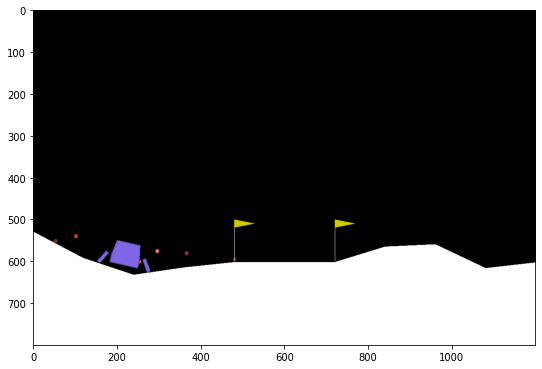

In [20]:
from IPython import display
env = gym.make('LunarLander-v2')
env.reset()
plt.figure(figsize=(9,9))

img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = np.random.randint(4)
    env.step(action)
env.close()

In [59]:
#Bi-Pedal Walker
env = gym.make("BipedalWalker-v3") #BipedalWalker-v3
obs = env.reset()
print(obs)
print(env.action_space)
#env.step([0,1,2,3])
for i in range(100):
    print(np.random.rand(4))
x = np.random.rand(4)
x = x.reshape(1,-1)
x.shape

[ 2.74597970e-03  9.67912434e-06 -1.26213223e-03 -1.60000634e-02
  9.24620405e-02  2.92997505e-03  8.59819293e-01 -9.26857193e-04
  1.00000000e+00  3.27851437e-02  2.92983907e-03  8.53547931e-01
 -1.99357110e-03  1.00000000e+00  4.40813392e-01  4.45819497e-01
  4.61422116e-01  4.89549488e-01  5.34102023e-01  6.02460206e-01
  7.09147871e-01  8.85930538e-01  1.00000000e+00  1.00000000e+00]
Box(4,)
[0.08387374 0.99280398 0.12718245 0.07234838]
[0.87853075 0.30183466 0.65029697 0.32900573]
[0.39145427 0.26211297 0.34304401 0.4107004 ]
[0.72041607 0.51153619 0.94356522 0.04188039]
[0.50306832 0.58422479 0.92019699 0.04915852]
[0.57349958 0.85362993 0.24192773 0.87629235]
[0.01904341 0.73245463 0.93311322 0.65719766]
[0.43902924 0.04488102 0.92011381 0.47029622]
[0.02899674 0.68982107 0.48183725 0.12434532]
[0.21427181 0.06449068 0.57429354 0.62202948]
[0.5057423  0.81710213 0.86100882 0.6156244 ]
[0.01275648 0.69522966 0.41799922 0.56555748]
[0.6490806  0.35023661 0.91709851 0.13397487]
[0.

/Users/nirajshah/.virtualenvs/cv-py3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


(1, 4)